In [113]:
import requests
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from power.ml_ops.data import get_pv_data, clean_pv_data
from power.ml_ops.model import model_yesterday
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [109]:
data = get_pv_data()
# data_clean = clean_pv_data(data)
n_years = 5
reduced_idx = 365 * 24 * n_years
df = data.iloc[-reduced_idx:,:].reset_index()

# Converting dates to datetime objects
df['local_time'] = pd.to_datetime(df['local_time'], utc=True)

# Setting dates as the index
df.set_index(['local_time'], inplace=True)

df

# data loaded


,index,Unnamed: 0.1,Unnamed: 0,electricity,irradiance_direct,irradiance_diffuse,temperature,source
local_time,,,,,,,,
2018-01-02 00:00:00+00:00,333144,24,1514851200000,0.0,0.0,0.0,1.558,data/pv_data/2018_pv.csv
2018-01-02 01:00:00+00:00,333145,25,1514854800000,0.0,0.0,0.0,1.474,data/pv_data/2018_pv.csv
2018-01-02 02:00:00+00:00,333146,26,1514858400000,0.0,0.0,0.0,1.524,data/pv_data/2018_pv.csv
2018-01-02 03:00:00+00:00,333147,27,1514862000000,0.0,0.0,0.0,1.504,data/pv_data/2018_pv.csv
2018-01-02 04:00:00+00:00,333148,28,1514865600000,0.0,0.0,0.0,1.635,data/pv_data/2018_pv.csv
...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00+00:00,376939,8755,1672513200000,0.0,0.0,0.0,12.240,data/pv_data/2022_pv.csv
2022-12-31 20:00:00+00:00,376940,8756,1672516800000,0.0,0.0,0.0,11.968,data/pv_data/2022_pv.csv
2022-12-31 21:00:00+00:00,376941,8757,1672520400000,0.0,0.0,0.0,11.953,data/pv_data/2022_pv.csv


In [110]:
def compress(df, **kwargs):
    """    Reduces size of dataframe by downcasting numerical columns    """
    input_size = df.memory_usage(index=True).sum()/ 1024
    print("new dataframe size: ", round(input_size,2), 'kB')

    in_size = df.memory_usage(index=True).sum()
    for type in ["float", "integer"]:
        l_cols = list(df.select_dtypes(include=type))
        for col in l_cols:
            df[col] = pd.to_numeric(df[col], downcast=type)
    out_size = df.memory_usage(index=True).sum()
    ratio = (1 - round(out_size / in_size, 2)) * 100

    print("optimized size by {} %".format(round(ratio,2)))
    print("new dataframe size: ", round(out_size / 1024,2), " kB")

    return df

compress(df)

new dataframe size:  3079.69 kB
optimized size by 36.0 %
new dataframe size:  1967.58  kB


,index,Unnamed: 0.1,Unnamed: 0,electricity,irradiance_direct,irradiance_diffuse,temperature,source
local_time,,,,,,,,
2018-01-02 00:00:00+00:00,333144,24,1514851200000,0.0,0.0,0.0,1.558,data/pv_data/2018_pv.csv
2018-01-02 01:00:00+00:00,333145,25,1514854800000,0.0,0.0,0.0,1.474,data/pv_data/2018_pv.csv
2018-01-02 02:00:00+00:00,333146,26,1514858400000,0.0,0.0,0.0,1.524,data/pv_data/2018_pv.csv
2018-01-02 03:00:00+00:00,333147,27,1514862000000,0.0,0.0,0.0,1.504,data/pv_data/2018_pv.csv
2018-01-02 04:00:00+00:00,333148,28,1514865600000,0.0,0.0,0.0,1.635,data/pv_data/2018_pv.csv
...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00+00:00,376939,8755,1672513200000,0.0,0.0,0.0,12.240,data/pv_data/2022_pv.csv
2022-12-31 20:00:00+00:00,376940,8756,1672516800000,0.0,0.0,0.0,11.968,data/pv_data/2022_pv.csv
2022-12-31 21:00:00+00:00,376941,8757,1672520400000,0.0,0.0,0.0,11.953,data/pv_data/2022_pv.csv


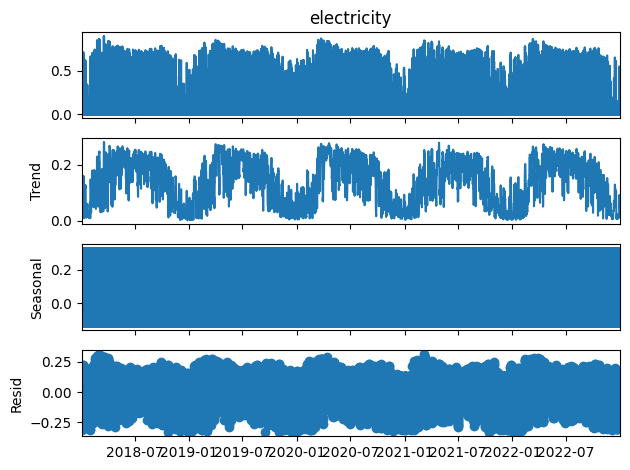

In [111]:
# Additive Decomposition (y = Trend + Seasonal + Residuals)
result_add = seasonal_decompose(df['electricity'], model='additive')
result_add.plot();

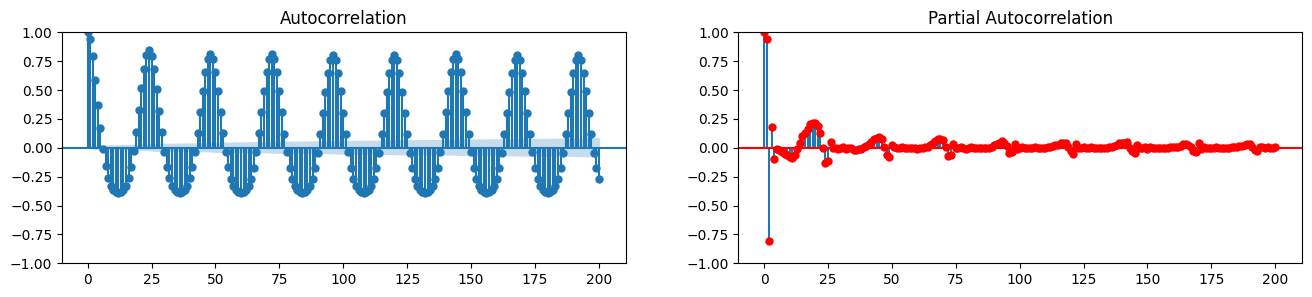

In [118]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1,2, figsize=(16,3))

plot_acf(df.electricity, lags=200, ax=axes[0]);
plot_pacf(df.electricity, lags=200, ax=axes[1], color='r');